In [29]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [16]:
# dataset

#rowingData = pd.read_csv('https://github.com/pippabarkley19/rowing-practice-prediction/blob/3f18cdceabbd0def7f63f98959258ff5c8ae7b72/rowing_data.csv')
uploaded = files.upload()
rowingData = pd.read_csv("rowing_data.csv")

rowingData.head()

  # temperature (degrees celcius) (float64)
  # lightning (T/F) (boolean)
  # wind (km/h) (int64)
  # visibility (km) (int64)
  # rowed (T/F) (boolean)

Saving rowing_data.csv to rowing_data (3).csv


,Date,Temperature,Lightning,Wind,Visibility,Rowed
0,2025/9/28,15,F,8,32,T
1,2025/10/25,11,F,22,48,F
2,2025/10/26,8,F,8,48,T
3,2025/11/1,12,F,13,48,T
4,2025/11/2,10,F,9,48,T


In [17]:
# drop date
rowingData.drop("Date", axis=1, inplace=True)

# pipeline for imputing numerical/ categorical feautres
numeric_features = ['Temperature', 'Wind', 'Visibility']
# exclude target
categorical_features = ['Lightning']

num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())

# create a pipeline to impute missing values with the most frequent value and one-hot encode categorical features
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

# create a column transformer to apply the numeric and categorical pipelines to the correct features
# use remainder='passthrough' to keep the remaining features in the dataframe
preprocessing = ColumnTransformer(transformers=[("num", num_pipeline, numeric_features),("cat", cat_pipeline, categorical_features)],remainder='passthrough')

rowing_prepared = preprocessing.fit_transform(rowingData)
# convert the result to a dataframe
# use the preprocessor's get_feature_names_out() method to get the column names
rowing_prepared = pd.DataFrame(rowing_prepared, columns=preprocessing.get_feature_names_out())


# display the first 5 rows of the preprocessed dataframe
rowing_prepared.head()


,num__Temperature,num__Wind,num__Visibility,cat__Lightning_F,remainder__Rowed
0,2.292136,-0.406409,-0.796254,1.0,T
1,0.293864,1.896577,0.470302,1.0,F
2,-1.204841,-0.406409,0.470302,1.0,T
3,0.793432,0.416086,0.470302,1.0,T
4,-0.205704,-0.24191,0.470302,1.0,T


In [18]:
# seperate features from target

y = rowingData["Rowed"]

#create X prepared set

X_prepared = rowing_prepared.drop("remainder__Rowed", axis=1)


In [19]:
# SGDClassifier for x,y

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_prepared, y)

SGDClassifier(random_state=42)

In [33]:
# print accuracy
scores = cross_val_score(sgd_clf, X_prepared, y, cv=2, scoring='accuracy')

mean_accuracy = scores.mean()

print(mean_accuracy)

# predict target on train set
y_train_pred = cross_val_predict(sgd_clf, X_prepared, y, cv=2)
print(y_train_pred)

# print confusion matrix
cm = confusion_matrix(y, y_train_pred, labels=['T', 'F'])

print(cm)

# compute and print precision and recall
precision = precision_score(y, y_train_pred)
print(precision)

recall = recall_score(y, y_train_pred)
print(recall)

0.7569444444444444
['T' 'F' 'T' 'F' 'T' 'T' 'T' 'T' 'T' 'F' 'T' 'T' 'T' 'T' 'T' 'T' 'F']
[[12  3]
 [ 1  1]]


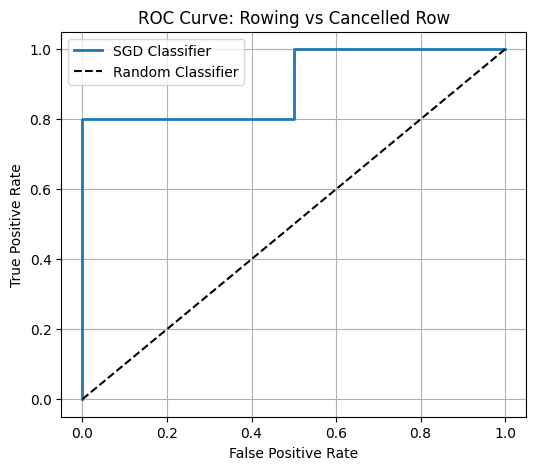

In [38]:
# call the result fpr, tpr, thresholds
y_scores = cross_val_predict(SGDClassifier(random_state=42), X_prepared, y, cv=2, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label = 'T')

# plot the roc curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="SGD Classifier")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Rowing vs Cancelled Row")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# make prediction on new values

newRowingData = [[10, 'F', 10, 48]]
new_df = pd.DataFrame(newRowingData, columns=['Temperature', 'Lightning', 'Wind', 'Visibility'])

# preprocess data

newData_numpy = preprocessing.transform(new_df)

feature_names = preprocessing.get_feature_names_out()
newData_prepared = pd.DataFrame(newData_numpy, columns=feature_names)

# prediction
prediction = sgd_clf.predict(newData_prepared)

if prediction[0] == 'T':
    print("Prediction: Gather the crew! (T)")
else:
    print("Prediction: Rowing is likely cancelled. (F)")

# print certainty
score = sgd_clf.decision_function(newData_prepared)

print(f"Classifier Score: {score[0]:.2f}")

Prediction: Get the boat ready! (T)
Classifier Score: 18.83
